In [1]:
%load_ext cmdstanjupyter

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
from scipy import special
import matplotlib.pyplot as plt
import arviz as ar

In [3]:
# l_2 distance squared
def l2_sq(a, b):
    temp = [v**2 for v in a - b]
    return np.sum(temp)

# Creating Sq-exp Gram matrix for just the baseline covariates

In [4]:
# STANDARD Squared Exponential Kernel function (isotropic scale parameter 'l') for feature vectors x1, x2
def K_sqexp(x1, x2, l):
        return np.exp(-l2_sq(x1, x2)/(l**2))

In [5]:
def create_sqexp_mat(X_mat, l):
    n = len(X_mat)
    out = np.zeros(shape = (n, n))
    for i in range(n - 1):
        for j in range(i + 1, n):
            out[j][i] = out[i][j] = K_sqexp(x1 = X_mat[i], x2 = X_mat[j], l = l)
    for i in range(n):
        out[i][i] = K_sqexp(x1 = X_mat[i], x2 = X_mat[i], l = l)
    return out

In [6]:
K_X_mat = create_sqexp_mat(X_mat = np.random.normal(size = (100, 10)), l = 1.0e-0)

# smallest absolute eigen-value
np.min(abs(linalg.eig(K_X_mat)[0]))

0.7420747373172563

# Polynomial kernel for d

$$ K_{l, c_0, p} \left( \left( \boldsymbol{x}_i, d_i \right), \left( \boldsymbol{x}_j, d_j \right) \right) 
:= \left( c_0 + d_i d_j \right)^p \exp \left[ - \frac{\| \boldsymbol{x}_i - \boldsymbol{x}_j \|_2^2}{2 l^2} \right], 
\; l > 0, \, c_0 > 0, \, p > 0 $$

In [7]:
def K_poly_d_mat(d_vec, c_0, p):
    n = len(d_vec)
    d = np.atleast_2d(d_vec)
    out = c_0 + np.matmul(d.reshape(n, 1), d)
    return out**p

In [8]:
KK = K_poly_d_mat(d_vec = np.random.uniform(size = 100), c_0 = 1, p = 2)

# smallest absolute eigen-value
np.min(abs(linalg.eig(KK)[0]))

8.461992121681261e-17

In [9]:
def create_K_full(X_mat, d_vec, l, c_0, p):
    return np.multiply(create_sqexp_mat(X_mat = X_mat, l = l), K_poly_d_mat(d_vec = d_vec, c_0 = c_0, p = p))

In [10]:
def create_K_vec(X_mat, d_vec, X_vec, d_scalar, l, c_0, p):
    return np.array([((c_0 + d_vec[i]*d_scalar)**p)*K_sqexp(X_mat[i], X_vec, l) for i in range(len(d_vec))])

In [11]:
K_vec = create_K_vec(X_mat = np.random.normal(size = (100, 10)), d_vec = np.random.uniform(size = 100), 
             X_vec = np.random.normal(size = 10), d_scalar = 0.9, l = 1.0e+1, c_0 = 1, p = 2)

In [12]:
K_vec

array([1.48016987, 0.77852746, 2.37826717, 2.22660984, 0.70601774,
       1.25356748, 1.63049524, 1.66998497, 0.91053847, 0.78732691,
       1.18661865, 2.46912951, 0.77969478, 2.26867252, 1.14018744,
       1.88538791, 2.12661305, 1.98935676, 0.85464325, 1.98596965,
       0.93782706, 0.7487438 , 1.53021811, 1.86234273, 1.78836088,
       0.97350167, 1.76950871, 1.71575973, 1.83180581, 1.77976283,
       1.96518536, 1.25021504, 1.10666697, 2.93700145, 1.3549606 ,
       1.41111625, 2.75418209, 1.58818727, 0.75285226, 2.81978177,
       1.18247345, 1.15643875, 2.01591069, 2.20383971, 1.00978956,
       2.52250919, 1.2873829 , 2.28074256, 2.02638422, 1.37720469,
       0.9093901 , 1.63781129, 2.35306806, 0.91511955, 2.08778574,
       2.90411054, 2.31217738, 1.61746537, 1.01319517, 1.71342475,
       2.05123914, 1.11661193, 2.30037475, 1.13312525, 1.70042367,
       1.58570885, 1.67795831, 2.02172999, 1.73324956, 2.42802125,
       1.21379762, 1.33790289, 1.93076928, 1.96004825, 1.64491

In [13]:
K_full = create_K_full(X_mat = np.random.normal(size = (100, 10)), 
                       d_vec = np.random.uniform(size = 100), l = 1.0e+1, c_0 = 1, p = 2)

# smallest absolute eigen-value
np.min(abs(linalg.eig(K_full)[0]))

0.00046854090418785744

In [16]:
%%stan d_model
functions{
    matrix create_K_new(matrix K_old, vector d, real c_0, int p, int s){
      matrix[s, s] K_new = rep_matrix(0, s, s);
      for(j in 1:s){
        for(i in 1:s){
          K_new[i, j] = K_old[i, j] * pow(c_0 + d[i]*d[j], 2);
        }
      }
      return K_new;
    }
}

data{
    int<lower = 0> s;
    int<lower = 0> p;
    vector[s] mu;
    real<lower = 0> c_0;
    matrix[s, s] K_old;
}

parameters{
    vector<lower=0, upper=1>[s] d;
}

model{
    mu ~ multi_normal(rep_vector(0, s), create_K_new(K_old, d, c_0, p, s));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/d_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "d_model"
INFO:cmdstanjupyter:StanModel now available as variable "d_model"!
 Compilation took a moment.


In [19]:
X_mat = np.random.normal(size = (100, 10))

In [20]:
K_old = create_sqexp_mat(X_mat = X_mat, l = 1.0e-0)

In [21]:
def update_d(mu, K_old, c_0, p):
    n = len(mu)
    data_d = {'s':n, 'p':p, 'c_0':c_0, 'mu':mu, 'K_old':K_old}
    fit_d = d_model.sample(data = data_d)
    out = list(fit_d.summary()['Mean'].iloc[1:])
    return out

In [22]:
update_d(mu = np.random.normal(size = 100), K_old = K_old, c_0 = 1, p = 2)

11:18:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:19:22 - cmdstanpy - INFO - CmdStan done processing.


[0.570753,
 0.462308,
 0.471192,
 0.447672,
 0.450299,
 0.445949,
 0.469429,
 0.545888,
 0.501364,
 0.462751,
 0.457581,
 0.660607,
 0.571283,
 0.445263,
 0.445074,
 0.440335,
 0.484717,
 0.457859,
 0.498027,
 0.44548,
 0.544465,
 0.437027,
 0.443597,
 0.47099,
 0.67156,
 0.461011,
 0.445493,
 0.520573,
 0.449803,
 0.560025,
 0.445603,
 0.471202,
 0.480248,
 0.461441,
 0.486353,
 0.45281,
 0.448198,
 0.455391,
 0.455714,
 0.446298,
 0.446862,
 0.461866,
 0.438055,
 0.519999,
 0.530621,
 0.440859,
 0.448102,
 0.458867,
 0.467877,
 0.492764,
 0.460293,
 0.458217,
 0.444741,
 0.441376,
 0.47392,
 0.444132,
 0.443121,
 0.511839,
 0.585612,
 0.468521,
 0.443255,
 0.475209,
 0.452988,
 0.432882,
 0.451159,
 0.455594,
 0.458169,
 0.445143,
 0.439785,
 0.522119,
 0.449947,
 0.459953,
 0.44951,
 0.444926,
 0.476498,
 0.452737,
 0.469509,
 0.441997,
 0.464663,
 0.443307,
 0.444333,
 0.448548,
 0.450622,
 0.45355,
 0.444223,
 0.481038,
 0.454997,
 0.462086,
 0.441975,
 0.444645,
 0.453878,
 0.450

In [23]:
def GP_mean(Y_vec, X_mat, d_vec, X_vec, d_scalar, l, c_0, p):
    n = len(Y_vec)
    v = create_K_vec(X_mat, d_vec, X_vec, d_scalar, l, c_0, p)
    M = linalg.inv(np.identity(n) + create_K_full(X_mat, d_vec, l, c_0, p))
    return np.dot(np.matmul(M, v), Y_vec)

In [24]:
GP_mean(Y_vec = np.random.normal(size = 100), X_mat = np.random.normal(size = (100, 10)),
        d_vec = np.random.uniform(size = 100), X_vec = np.random.normal(size = 10), d_scalar = 0.5,
        l = 1.0e+1, c_0 = 1, p = 2)

0.04113693934068077

In [54]:
def update_mu(Y_vec, X_mat, d_vec, l, c_0, p):
    n = len(Y_vec)
    K_full = create_K_full(X_mat, d_vec, l, c_0, p)
    cov = linalg.inv(linalg.inv(K_full) + np.identity(n))
    mu = np.random.multivariate_normal(mean = np.matmul(cov, Y_vec), cov = cov)
    return mu

In [55]:
update_mu(Y_vec = np.random.normal(size = 100), X_mat = np.random.normal(size = (100, 10)), 
          d_vec = np.random.uniform(size = 100), l = 1.0e+1, c_0 = 1, p = 2)

array([-2.13055180e-01,  5.43149982e-02,  2.39358780e-01, -1.51678935e-01,
       -2.98551782e-01, -2.83907841e-01, -3.22342276e-01, -1.34199253e-03,
       -8.51514791e-01,  5.36686172e-01,  2.16246872e-01, -7.96992225e-01,
        4.86117810e-01, -1.71659355e-01, -2.81368450e-02, -1.06552803e-01,
       -2.04164717e-01, -4.63060944e-01, -1.59444522e-01,  1.08076739e-01,
        4.83810191e-01, -5.07474689e-01, -1.20598274e-01, -5.74876037e-01,
       -5.60428382e-01,  2.05417722e-01, -1.95237486e-01, -3.48711049e-01,
       -8.25243904e-02, -1.42044995e-01, -4.90398507e-01, -2.05859454e-01,
       -1.10367043e+00,  9.18609246e-02, -8.78916840e-01, -3.49926905e-01,
        6.01024148e-01, -1.24396736e-01, -1.61628450e-02, -9.20182629e-01,
        3.55504819e-01,  1.52365159e-01, -1.39848483e-01, -1.76653058e-01,
       -4.79201369e-01, -3.93349929e-01,  1.41172234e-01,  5.22327040e-01,
        8.29711693e-02, -3.21230930e-01,  1.81868031e-01, -8.91033329e-01,
       -1.65078461e-01, -

In [64]:
def update_all(n_iter, Y_vec, X_mat, l, c_0, p):
    n = len(Y_vec)
    K_old = create_sqexp_mat(X_mat = X_mat, l = l)
    
    # initializing
    d_vec = np.random.uniform(size = n)
    
    mu_mat = []
    d_mat = []
    
    # iteration
    for j in range(n_iter):
        mu = update_mu(Y_vec, X_mat, d_vec, l, c_0, p)
        d_vec = update_d(mu, K_old, c_0, p)
        
        # storing all draws
        mu_mat = mu_mat + [mu]
        d_mat = d_mat + [d_vec]
    return {'mu_mat':np.array(mu_mat), 'd_mat':d_mat}

## True Y data generation

In [61]:
# run this only once !!
X_given = np.random.normal(size = (100, 10))
d_true = np.ones(100)/3

In [62]:
def f_true(X_vec, d_scalar):
    return np.dot(X_vec, X_vec)/len(X_vec) + d_scalar**2

In [63]:
Y_vec = np.array([f_true(X_vec = X_given[i], d_scalar = d_true[i]) for i in range(len(d_true))])

In [ ]:
update_all(n_iter, Y_vec, X_mat, d_vec, l, c_0, p)

In [68]:
full = update_all(n_iter = 100, Y_vec = Y_vec, X_mat = X_given, l = 1.0e+1, c_0 = 1, p = 2)

16:07:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:09:47 - cmdstanpy - INFO - CmdStan done processing.


16:09:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:10:52 - cmdstanpy - INFO - CmdStan done processing.


16:10:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:12:27 - cmdstanpy - INFO - CmdStan done processing.


16:12:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:13:26 - cmdstanpy - INFO - CmdStan done processing.


16:13:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:14:40 - cmdstanpy - INFO - CmdStan done processing.


16:14:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:15:31 - cmdstanpy - INFO - CmdStan done processing.


16:15:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:16:16 - cmdstanpy - INFO - CmdStan done processing.


16:16:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:17:12 - cmdstanpy - INFO - CmdStan done processing.


16:17:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:18:33 - cmdstanpy - INFO - CmdStan done processing.


16:18:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:19:30 - cmdstanpy - INFO - CmdStan done processing.


16:19:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:21:00 - cmdstanpy - INFO - CmdStan done processing.


16:21:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:21:59 - cmdstanpy - INFO - CmdStan done processing.


16:22:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:23:16 - cmdstanpy - INFO - CmdStan done processing.


16:23:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:24:10 - cmdstanpy - INFO - CmdStan done processing.


16:24:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:25:05 - cmdstanpy - INFO - CmdStan done processing.


16:25:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:26:54 - cmdstanpy - INFO - CmdStan done processing.


16:26:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:28:34 - cmdstanpy - INFO - CmdStan done processing.


16:28:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:29:31 - cmdstanpy - INFO - CmdStan done processing.


16:29:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:30:26 - cmdstanpy - INFO - CmdStan done processing.


16:30:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:31:37 - cmdstanpy - INFO - CmdStan done processing.


16:31:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:27 - cmdstanpy - INFO - CmdStan done processing.


16:34:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:36:21 - cmdstanpy - INFO - CmdStan done processing.


16:36:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:27 - cmdstanpy - INFO - CmdStan done processing.


16:37:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:39:16 - cmdstanpy - INFO - CmdStan done processing.


16:39:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:41:23 - cmdstanpy - INFO - CmdStan done processing.


16:41:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:42:46 - cmdstanpy - INFO - CmdStan done processing.


16:42:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:43:39 - cmdstanpy - INFO - CmdStan done processing.


16:43:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:44:38 - cmdstanpy - INFO - CmdStan done processing.


16:44:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:45:38 - cmdstanpy - INFO - CmdStan done processing.


16:45:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:46:32 - cmdstanpy - INFO - CmdStan done processing.


16:46:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:47:29 - cmdstanpy - INFO - CmdStan done processing.


16:47:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:48:37 - cmdstanpy - INFO - CmdStan done processing.


16:48:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:33 - cmdstanpy - INFO - CmdStan done processing.


16:50:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:51:35 - cmdstanpy - INFO - CmdStan done processing.


16:51:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:52:31 - cmdstanpy - INFO - CmdStan done processing.


16:52:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:53:21 - cmdstanpy - INFO - CmdStan done processing.


16:53:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:55:10 - cmdstanpy - INFO - CmdStan done processing.


16:55:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:56:18 - cmdstanpy - INFO - CmdStan done processing.


16:56:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:57:19 - cmdstanpy - INFO - CmdStan done processing.


16:57:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:58:20 - cmdstanpy - INFO - CmdStan done processing.


16:58:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:59:22 - cmdstanpy - INFO - CmdStan done processing.


16:59:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:00:32 - cmdstanpy - INFO - CmdStan done processing.


17:00:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:01:23 - cmdstanpy - INFO - CmdStan done processing.


17:01:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:02:17 - cmdstanpy - INFO - CmdStan done processing.


17:02:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:03:21 - cmdstanpy - INFO - CmdStan done processing.


17:03:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:05:14 - cmdstanpy - INFO - CmdStan done processing.


17:05:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:06:30 - cmdstanpy - INFO - CmdStan done processing.


17:06:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:07:28 - cmdstanpy - INFO - CmdStan done processing.


17:07:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:08:27 - cmdstanpy - INFO - CmdStan done processing.


17:08:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:09:56 - cmdstanpy - INFO - CmdStan done processing.


17:09:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:11:02 - cmdstanpy - INFO - CmdStan done processing.


17:11:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:12:27 - cmdstanpy - INFO - CmdStan done processing.


17:12:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:13:27 - cmdstanpy - INFO - CmdStan done processing.


17:13:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:14:28 - cmdstanpy - INFO - CmdStan done processing.


17:14:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:15:30 - cmdstanpy - INFO - CmdStan done processing.


17:15:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:16:29 - cmdstanpy - INFO - CmdStan done processing.


17:16:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:18:31 - cmdstanpy - INFO - CmdStan done processing.


17:18:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:20:37 - cmdstanpy - INFO - CmdStan done processing.


17:20:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:21:39 - cmdstanpy - INFO - CmdStan done processing.


17:21:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:22:53 - cmdstanpy - INFO - CmdStan done processing.


17:22:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:24:00 - cmdstanpy - INFO - CmdStan done processing.


17:24:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:25:31 - cmdstanpy - INFO - CmdStan done processing.


17:25:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:26:31 - cmdstanpy - INFO - CmdStan done processing.


17:26:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:11 - cmdstanpy - INFO - CmdStan done processing.


17:28:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:29:54 - cmdstanpy - INFO - CmdStan done processing.


17:29:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:31:28 - cmdstanpy - INFO - CmdStan done processing.


17:31:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:32:23 - cmdstanpy - INFO - CmdStan done processing.


17:32:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:33:17 - cmdstanpy - INFO - CmdStan done processing.


17:33:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:20 - cmdstanpy - INFO - CmdStan done processing.


17:34:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:21 - cmdstanpy - INFO - CmdStan done processing.


17:35:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:37:41 - cmdstanpy - INFO - CmdStan done processing.


17:37:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:39:29 - cmdstanpy - INFO - CmdStan done processing.


17:39:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:40:37 - cmdstanpy - INFO - CmdStan done processing.


17:40:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:41:41 - cmdstanpy - INFO - CmdStan done processing.


17:41:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:44:20 - cmdstanpy - INFO - CmdStan done processing.


17:44:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:45:19 - cmdstanpy - INFO - CmdStan done processing.


17:45:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:46:13 - cmdstanpy - INFO - CmdStan done processing.


17:46:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:47:12 - cmdstanpy - INFO - CmdStan done processing.


17:47:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:48:07 - cmdstanpy - INFO - CmdStan done processing.


17:48:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:48:50 - cmdstanpy - INFO - CmdStan done processing.


17:48:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:49:48 - cmdstanpy - INFO - CmdStan done processing.


17:49:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:50:52 - cmdstanpy - INFO - CmdStan done processing.


17:50:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:51 - cmdstanpy - INFO - CmdStan done processing.


17:51:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:52:52 - cmdstanpy - INFO - CmdStan done processing.


17:52:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:53:50 - cmdstanpy - INFO - CmdStan done processing.


17:53:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:54:49 - cmdstanpy - INFO - CmdStan done processing.


17:54:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:55:52 - cmdstanpy - INFO - CmdStan done processing.


17:55:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:57:06 - cmdstanpy - INFO - CmdStan done processing.


17:57:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:58:10 - cmdstanpy - INFO - CmdStan done processing.


17:58:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:59:10 - cmdstanpy - INFO - CmdStan done processing.


17:59:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:00:08 - cmdstanpy - INFO - CmdStan done processing.


18:00:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:01:05 - cmdstanpy - INFO - CmdStan done processing.


18:01:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:02:01 - cmdstanpy - INFO - CmdStan done processing.


18:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:03:02 - cmdstanpy - INFO - CmdStan done processing.


18:03:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:04:05 - cmdstanpy - INFO - CmdStan done processing.


18:04:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:05:07 - cmdstanpy - INFO - CmdStan done processing.


18:05:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:06:39 - cmdstanpy - INFO - CmdStan done processing.


18:06:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:39 - cmdstanpy - INFO - CmdStan done processing.


18:07:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:09:14 - cmdstanpy - INFO - CmdStan done processing.


18:09:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:06 - cmdstanpy - INFO - CmdStan done processing.


In [69]:
full['d_mat'][-1]

[0.483465,
 0.459898,
 0.465082,
 0.463963,
 0.463484,
 0.454684,
 0.647376,
 0.570704,
 0.483604,
 0.479069,
 0.454389,
 0.452777,
 0.457326,
 0.516817,
 0.477065,
 0.484238,
 0.448352,
 0.467845,
 0.456321,
 0.405743,
 0.461717,
 0.453809,
 0.474635,
 0.507528,
 0.489695,
 0.44796,
 0.478298,
 0.49841,
 0.480302,
 0.431025,
 0.486752,
 0.461586,
 0.429196,
 0.466517,
 0.479891,
 0.456531,
 0.483409,
 0.538032,
 0.469875,
 0.413241,
 0.460963,
 0.46232,
 0.481391,
 0.457177,
 0.443234,
 0.498266,
 0.499135,
 0.46522,
 0.478022,
 0.45247,
 0.466121,
 0.566192,
 0.490239,
 0.459275,
 0.756842,
 0.443939,
 0.471578,
 0.473882,
 0.453107,
 0.468129,
 0.433713,
 0.505281,
 0.509861,
 0.481211,
 0.475239,
 0.467228,
 0.559563,
 0.523159,
 0.510263,
 0.475469,
 0.444804,
 0.484579,
 0.470447,
 0.448788,
 0.44867,
 0.568181,
 0.463102,
 0.463919,
 0.455325,
 0.456202,
 0.530235,
 0.445435,
 0.513879,
 0.483295,
 0.492332,
 0.455526,
 0.396594,
 0.59547,
 0.469611,
 0.463201,
 0.453875,
 0.458

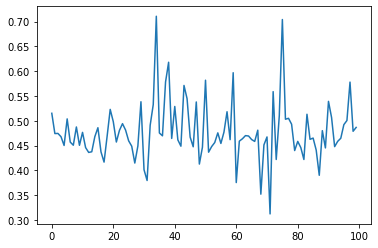

In [73]:
plt.plot(np.array(full['d_mat']).T[30])

# No $\mu$ updates:

In [15]:
%%stan d_model
functions{
    matrix create_K_new(matrix K_old, vector d, real sigma, real c_0, int p, int s){
      matrix[s, s] K_new = rep_matrix(0, s, s);
      for(j in 1:s){
        for(i in 1:s){
            if(i == j){
                K_new[i, j] = pow(sigma, 2) + K_old[i, j] * pow(c_0 + d[i]*d[j], 2);
            }
            else{
                K_new[i, j] = K_old[i, j] * pow(c_0 + d[i]*d[j], 2);
            }
        }
      }
      return K_new;
    }
}

data{
    int<lower = 0> s;
    int<lower = 0> p;
    vector[s] Y;
    real<lower = 0> c_0;
    real<lower = 0> sigma;
    matrix[s, s] K_old;
}

parameters{
    vector<lower=0, upper=1>[s] d;
}

model{
    Y ~ multi_normal(rep_vector(0, s), create_K_new(K_old, d, sigma, c_0, p, s));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/d_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "d_model"
INFO:cmdstanjupyter:StanModel now available as variable "d_model"!
 Compilation took a moment.


In [38]:
X_mat = np.random.normal(size = (100, 10))
K_old = create_sqexp_mat(X_mat = X_mat, l = 1.0e-0)

In [44]:
def update_d(Y_vec, K_old, sigma, c_0, p):
    n = len(Y_vec)
    data_d = {'s':n, 'p':p, 'c_0':c_0, 'Y':Y_vec, 'sigma':sigma, 'K_old':K_old}
    fit_d = d_model.sample(data = data_d)
    out = list(fit_d.summary()['Mean'].iloc[1:])
    return out

In [16]:
n_samples = 100
X_given = np.random.normal(size = (n_samples, 10))
d_true = np.ones(n_samples)/3
K_old = create_sqexp_mat(X_mat = X_given, l = 1.0e-0)

def f_true(X_vec, d_scalar):
    return 2*np.sum(X_vec) + 5*d_scalar

#Y_vec = np.random.normal(size = n_samples)
#Y_vec = np.array([f_true(X_vec = X_given[i], d_scalar = d_true[i]) for i in range(len(d_true))])
Y_vec = np.random.multivariate_normal(mean = np.zeros(n_samples), 
                                      cov = 0.01*np.identity(n_samples) 
                                      + create_K_full(X_given, d_true, l = 1.0e-0, c_0 = 1, p = 3))

n = len(Y_vec)
data_d = {'s':n_samples, 'p':3, 'c_0':1, 'Y':Y_vec, 'sigma':0.01, 'K_old':K_old}
fit_d = d_model.sample(data = data_d)

17:33:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:11 - cmdstanpy - INFO - CmdStan done processing.


In [22]:
create_K_full(X_given, d_true, l = 1.0e-0, c_0 = 1, p = 3)

array([[1.37174211e+00, 1.82293018e-06, 8.61105035e-07, ...,
        6.62046967e-08, 7.80206225e-11, 1.65349546e-04],
       [1.82293018e-06, 1.37174211e+00, 3.27492306e-06, ...,
        1.94212665e-07, 5.02131613e-05, 3.39353069e-08],
       [8.61105035e-07, 3.27492306e-06, 1.37174211e+00, ...,
        6.83946388e-08, 1.43658337e-04, 1.10887945e-11],
       ...,
       [6.62046967e-08, 1.94212665e-07, 6.83946388e-08, ...,
        1.37174211e+00, 1.18186155e-13, 1.25686274e-09],
       [7.80206225e-11, 5.02131613e-05, 1.43658337e-04, ...,
        1.18186155e-13, 1.37174211e+00, 3.75009201e-14],
       [1.65349546e-04, 3.39353069e-08, 1.10887945e-11, ...,
        1.25686274e-09, 3.75009201e-14, 1.37174211e+00]])

In [17]:
d_draws = fit_d.stan_variable(var = 'd')

(array([562., 474., 463., 447., 425., 429., 332., 303., 302., 263.]),
 array([7.97143000e-05, 1.00051843e-01, 2.00023971e-01, 2.99996100e-01,
        3.99968229e-01, 4.99940357e-01, 5.99912486e-01, 6.99884614e-01,
        7.99856743e-01, 8.99828871e-01, 9.99801000e-01]),
 <BarContainer object of 10 artists>)

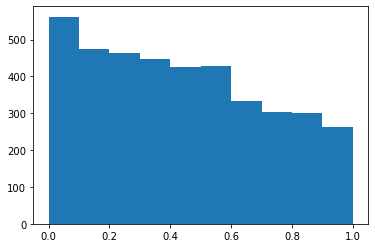

In [18]:
plt.hist(d_draws.T[0])

(array([473., 466., 468., 462., 427., 422., 387., 333., 287., 275.]),
 array([2.01531000e-04, 1.00076978e-01, 1.99952425e-01, 2.99827872e-01,
        3.99703319e-01, 4.99578765e-01, 5.99454212e-01, 6.99329659e-01,
        7.99205106e-01, 8.99080553e-01, 9.98956000e-01]),
 <BarContainer object of 10 artists>)

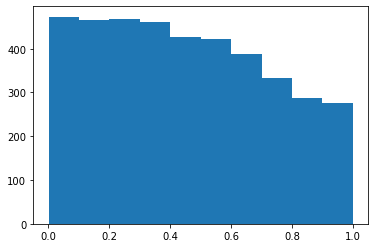

In [19]:
plt.hist(d_draws.T[50])

(array([449., 490., 458., 459., 439., 386., 359., 378., 323., 259.]),
 array([2.67372000e-04, 1.00199035e-01, 2.00130698e-01, 3.00062360e-01,
        3.99994023e-01, 4.99925686e-01, 5.99857349e-01, 6.99789012e-01,
        7.99720674e-01, 8.99652337e-01, 9.99584000e-01]),
 <BarContainer object of 10 artists>)

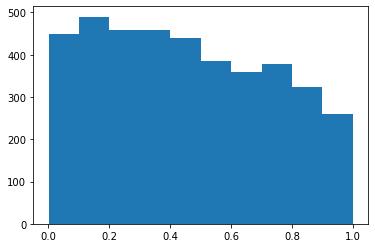

In [20]:
plt.hist(d_draws.T[99])

(array([431., 420., 413., 432., 422., 425., 383., 384., 363., 327.]),
 array([1.65055000e-04, 1.00146449e-01, 2.00127844e-01, 3.00109239e-01,
        4.00090633e-01, 5.00072028e-01, 6.00053422e-01, 7.00034816e-01,
        8.00016211e-01, 8.99997605e-01, 9.99979000e-01]),
 <BarContainer object of 10 artists>)

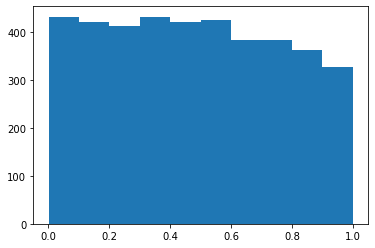

In [21]:
plt.hist(d_draws.T[90])

In [45]:
# run this only once !!
X_given = np.random.normal(size = (100, 10))
d_true = np.ones(100)/10

In [46]:
def f_true(X_vec, d_scalar):
    return 2*np.sum(X_vec) + 5*d_scalar

In [47]:
Y_vec = np.array([f_true(X_vec = X_given[i], d_scalar = d_true[i]) for i in range(len(d_true))])

In [49]:
d_est = update_d(Y_vec = Y_vec, K_old = K_old, sigma = 1, c_0 = 1, p = 2)

12:52:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:52:30 - cmdstanpy - INFO - CmdStan done processing.


In [50]:
d_est

[0.548769,
 0.63207,
 0.948912,
 0.643452,
 0.763798,
 0.506079,
 0.530864,
 0.659286,
 0.467198,
 0.560637,
 0.778133,
 0.534339,
 0.571915,
 0.963849,
 0.839103,
 0.965036,
 0.553773,
 0.616754,
 0.869455,
 0.832953,
 0.672266,
 0.535884,
 0.638909,
 0.88749,
 0.49554,
 0.974517,
 0.485479,
 0.808636,
 0.920672,
 0.521069,
 0.81851,
 0.811915,
 0.717636,
 0.880112,
 0.91393,
 0.935417,
 0.51843,
 0.576265,
 0.707928,
 0.671319,
 0.785116,
 0.570865,
 0.936851,
 0.4633,
 0.657275,
 0.923729,
 0.886817,
 0.848813,
 0.943696,
 0.550708,
 0.822441,
 0.77768,
 0.923977,
 0.4651,
 0.542936,
 0.593189,
 0.967269,
 0.551233,
 0.807456,
 0.963248,
 0.511977,
 0.532289,
 0.967105,
 0.825075,
 0.5225,
 0.496097,
 0.652683,
 0.813851,
 0.46719,
 0.922678,
 0.927561,
 0.469603,
 0.896402,
 0.587785,
 0.872831,
 0.915165,
 0.964352,
 0.927043,
 0.950155,
 0.800416,
 0.944281,
 0.923437,
 0.507497,
 0.529636,
 0.517358,
 0.89185,
 0.824345,
 0.621929,
 0.724714,
 0.522364,
 0.480272,
 0.925948,
 0.

In [51]:
GP_mean(Y_vec = Y_vec, X_mat = X_given,
        d_vec = d_est, X_vec = np.ones(10), d_scalar = 0.5,
        l = 1.0e+1, c_0 = 1, p = 2)

10.562311563301343

In [33]:
###############################################################################################################################

# Creating 'Warped' Sq-exp Gram matrix for unknown covariate

## Logit Warping

In [8]:
# modified Squared Exponential Kernel function for scalars d1, d2
def K_warp_sqexp(d1, d2, l):
        return np.exp(-((special.logit(d1) - special.logit(d2))/l)**2)

In [9]:
K_warp_sqexp(d1 = 0.9, d2 = 0.1, l = 1)

4.1044939710641305e-09

In [10]:
def create_warp_sqexp_mat(d_vec, l):
    n = len(d_vec)
    out = np.zeros(shape = (n, n))
    for i in range(n - 1):
        for j in range(i + 1, n):
            out[j][i] = out[i][j] = K_warp_sqexp(d1 = d_vec[i], d2 = d_vec[j], l = l)
    for i in range(n):
        out[i][i] = K_warp_sqexp(d1 = d_vec[i], d2 = d_vec[i], l = l)
    return out

In [11]:
K_d_mat = create_warp_sqexp_mat(d_vec = np.random.uniform(size = 100), l = 1.0e-3)

# smallest absolute eigen-value
np.min(abs(linalg.eig(K_d_mat)[0]))

0.2619376586416067

In [12]:
K_d_mat[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## Sin Warping

In [ ]:
# modified Squared Exponential Kernel function for scalars d1, d2
def K_warp_sqexp(d1, d2, l):
        return np.exp(-((special.logit(d1) - special.logit(d2))/l)**2)

# Creating Full Gram matrix for all covariates (with warping)

In [13]:
def create_K_full(X_mat, d_vec, l_X, l_d):
    return np.multiply(create_sqexp_mat(X_mat = X_mat, l = l_X), create_warp_sqexp_mat(d_vec = d_vec, l = l_d))

In [14]:
K_full = create_K_full(X_mat = np.random.normal(size = (100, 4)), d_vec = np.random.uniform(size = 100), l_X = 1, l_d = 1)

# smallest absolute eigen-value
np.min(abs(linalg.eig(K_full)[0]))

0.12223416367883085

In [4]:
def create_K_prod_mat(X_mat, c_0 = 1, offset = 0.5, p = 2):
    mat = X_mat - offset
    out = c_0 + np.matmul(mat, mat.T)
    return out**p

In [66]:
KK = create_K_prod_mat(X_mat = np.random.normal(size = (50, 5)), c_0 = 1, offset = 0.5)

# smallest absolute eigen-value
np.min(abs(linalg.eig(KK)[0]))

3.233355286790019e-17

In [9]:
def create_K_prod_vec(X_mat, X_vec, c_0 = 0, offset = 0.5):
    mat = X_mat - offset
    vec = X_vec - offset
    vec = np.atleast_2d(vec)
    out = c_0 + np.matmul(mat, vec.T)
    return np.ravel(out)

In [10]:
create_K_prod_vec(X_mat = np.random.normal(size = (4, 2)), X_vec = np.random.normal(size = 2), c_0 = 0, offset = 0.5)

array([ 1.06123573, -0.08387609, -0.56225959,  4.44628528])

In [11]:
def create_X_mat(x, u):
    n = len(x)
    return np.array([[x[i], u[i]] for i in range(n)])

In [12]:
def GP_mean(y_vec, X_mat, x_vec):
    n = len(y_vec)
    v = kernel_vec_sqexp(X_mat, x_vec, l = 1)
    M = linalg.inv(np.identity(n) + kernel_sqexp(X_mat, l = 1))
    return np.dot(np.matmul(M, v), y_vec)

In [13]:
def update_mu(y, x, u, c_0 = 1, offset = 0.5):
    n = len(y)
    X_mat = create_X_mat(x, u)
    K_prod_mat = create_K_prod_mat(X_mat, c_0, offset)
    cov = linalg.inv(linalg.inv(K_prod_mat) + np.identity(n))
    mu = np.random.multivariate_normal(mean = np.matmul(cov, y), cov = cov)
    return mu

In [22]:
%%stan u_model
functions{
    matrix create_K_mat(vector x, vector u, real c_0, real offset_val, int p, int n){
        matrix[n, n] K_mat = rep_matrix(0, n, n);
        for(j in 1:n){
            for(i in 1:n){
                K_mat[i, j] = pow(c_0 + (x[i] - offset_val)*(x[j] - offset_val) + (u[i] - offset_val)*(u[j] - offset_val), p);
            }
        }
        return K_mat;
    }
}

data{
    int<lower = 0> n;
    int<lower=1> p;
    real<lower=0> c_0;
    real offset_val;
    vector[n] mu;
    vector[n] x;
}

parameters{
    vector<lower=0, upper=1>[n] u;
}

model{
    mu ~ multi_normal(rep_vector(0, n), create_K_mat(x, u, c_0, offset_val, p, n));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/u_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "u_model"
INFO:cmdstanjupyter:StanModel now available as variable "u_model"!
 Compilation took a moment.


In [23]:
def update_u(mu, x, c_0, offset, p):
    n = len(x)
    data_u = {'n':n, 'p':p, 'c_0':c_0, 'offset_val':offset, 'mu':mu, 'x':x}
    fit_u = u_model.sample(data = data_u)
    out = list(fit_u.summary()['Mean'].iloc[1:])
    return out

In [39]:
update_u(mu = np.random.normal(size = 50), x = np.random.normal(size = 50), c_0 = 1, offset = 0.5, p = 3)

15:38:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:38:40 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
15:38:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:38:40 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
15:38:40 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted


15:38:40 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.32907e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.77316e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.55112e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -7.77156e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 9.10383e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.88338e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.9952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.64153e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.86517e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.32907e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.79856e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.43929e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.77316e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.21725e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.55112e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -9.32587e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 7.77156e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.9952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.44329e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.43929e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 9.99201e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 7.99361e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.46549e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.43929e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.9952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.41949e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.88338e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -9.10383e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.84297e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.66294e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.75415e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.66294e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['D:\\Python Files\\.stan\\u_model.exe', 'id=1', 'random', 'seed=73172', 'data', 'file=C:\\Users\\biraj\\AppData\\Local\\Temp\\tmp644n0d8y\\wszsgpwf.json', 'output', 'file=C:\\Users\\biraj\\AppData\\Local\\Temp\\tmp644n0d8y\\u_modeln3awkzq2\\u_model-20221110153840_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\biraj\AppData\Local\Temp\tmp644n0d8y\u_modeln3awkzq2\u_model-20221110153840_1.csv
 console_msgs (if any):
	C:\Users\biraj\AppData\Local\Temp\tmp644n0d8y\u_modeln3awkzq2\u_model-20221110153840_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [158]:
def update_all(n_iter, y, x, c_0, offset, p):
    n = len(x)
    # initializing
    u = np.random.uniform(size = n)
    
    mu_mat = []
    u_mat = []
    
    # iteration
    for j in range(n_iter):
        mu = update_mu(y, x, u, c_0, offset)
        u = update_u(mu, x, c_0, offset, p)
        # storing all draws
        mu_mat = mu_mat + [mu]
        u_mat = u_mat + [u]
    return {'mu_mat':mu_mat, 'u_mat':u_mat}

In [159]:
x = np.random.normal(scale = 1, size = n)
u_true = np.ones(n)/3
y = f_true(x, u_true)

In [160]:
full = update_all(n_iter = 5, y = y, x = x, c_0 = 1, offset = 0.5, p = 2)

C:\Users\biraj\AppData\Local\Temp\ipykernel_215132\2242004715.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  mu = np.random.multivariate_normal(mean = np.matmul(cov, y), cov = cov)
13:49:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:20 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
13:49:20 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
13:49:20 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
13:49:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


13:49:20 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.88338e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.55112e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.55351e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.66294e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.21725e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.77316e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.22125e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.43929e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -7.10543e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.02061e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.19904e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.70894e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 7.32747e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.43929e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.65974e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.15463e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.43769e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.21725e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.06342e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 5.9952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.10942e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -9.32587e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.55271e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.10862e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.88338e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.9968e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -7.77156e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.88498e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.31006e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.21725e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -7.10543e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 3.77476e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.66294e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.21885e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -3.33067e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.95399e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -7.54952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.66454e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.19904e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.10703e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.39808e-014. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.33227e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 2.88658e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -6.21725e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.11022e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.77636e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 8.88178e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.22045e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 1.9984e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 6.66134e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 7.32747e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -1.55431e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -5.32907e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.44089e-016. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 7.54952e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -2.44249e-015. (in 'D:/PYTHON~1/STAN~1/u_model.stan', line 27, column 4 to column 83)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['D:\\Python Files\\.stan\\u_model.exe', 'id=1', 'random', 'seed=17938', 'data', 'file=C:\\Users\\biraj\\AppData\\Local\\Temp\\tmp0we9rzt1\\rg7_3mp3.json', 'output', 'file=C:\\Users\\biraj\\AppData\\Local\\Temp\\tmp0we9rzt1\\u_model0ie1sgwd\\u_model-20221108134920_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\biraj\AppData\Local\Temp\tmp0we9rzt1\u_model0ie1sgwd\u_model-20221108134920_1.csv
 console_msgs (if any):
	C:\Users\biraj\AppData\Local\Temp\tmp0we9rzt1\u_model0ie1sgwd\u_model-20221108134920_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [13]:
# new kernel matrix (only d_bar part)
def kernel_d_mat(d_bar, l, nu):
    n = len(d_bar)
    out = np.array([[None]*n]*n, dtype = 'float32')
    for i in range(n):
        out[i][i] = K_val(d_bar[i], d_bar[i], l, nu)
    for i in range(n - 1):
        for j in range(i + 1, n):
            out[i][j] = out[j][i] = K_val(d_bar[i], d_bar[j], l, nu)
    return out